This does the full cycle for active learning and aligning bags. But first: remove the folder in src/alignflow_master/ckpts/normalaligner!!!

In [1]:
versionname = "Original"
original = False
al_strategy = "entropy"
load = True

In [2]:
## Imports

import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
k = 30
nbags = 10
bag_contfactor = .4
seed = 1302

In [4]:
## Construct dataset
# 15 bags
# 35 instances/bag
import sys
from PUMILADmain.create_ds_2 import gen_data



bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = seed)
X_inst = X_inst[:,:2]
newb = {}
for k, v in bags.items():
    newb[k] = v[:,:2]
bags = newb

In [5]:
D = bags
bags = np.array(list(D.values()))
print(list(y_inst))
print(bags)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [6]:
import sys
sys.path.insert(1, '../')
from dataBag import DataBag
from rewardInfo import RewardInfo

dataBag = DataBag(bags, bags_labels, X_inst, y_inst)
rewardInfo = RewardInfo(len(bags_labels))

clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']

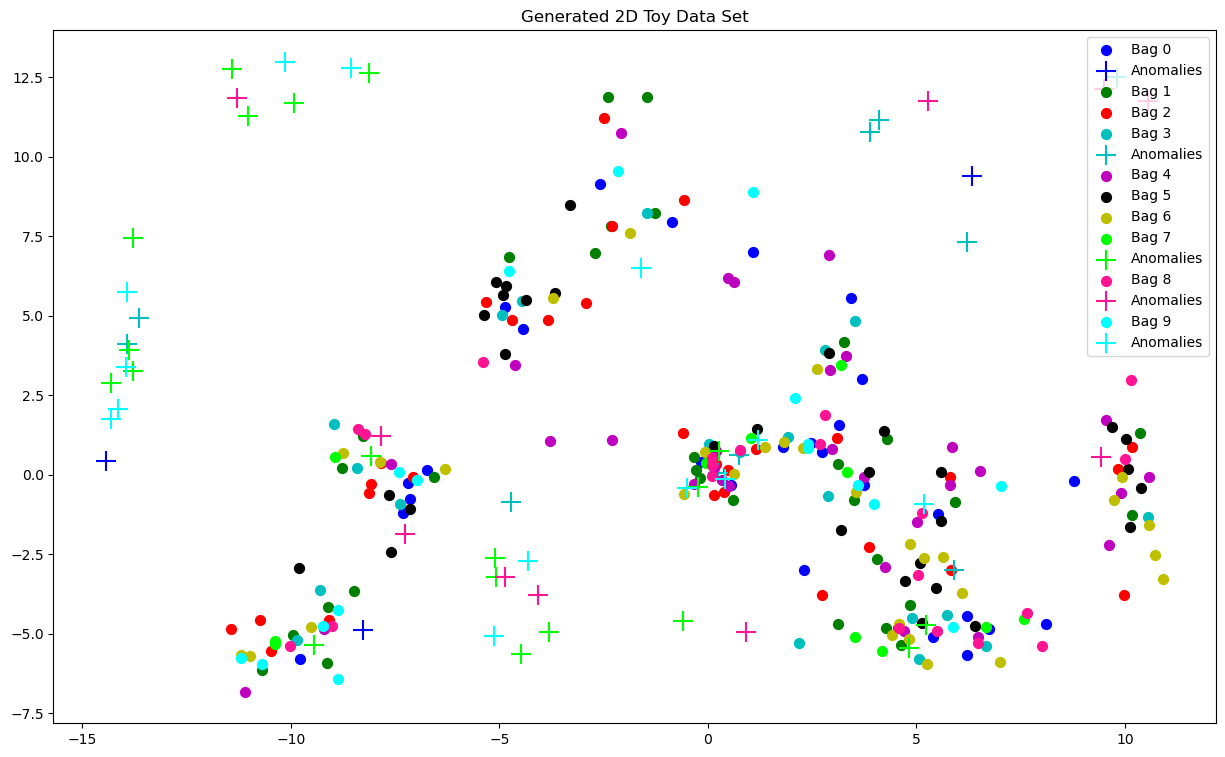

In [7]:
## Create toy data set

from itertools import cycle
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

for bag in range(len(bags)):
    domain = bags[bag]
    anomalies = []
    normals = []
    D[bag] = np.asarray(domain.tolist())

    for idx in range(len(domain)):
        if dataBag.isAnomaly(bag, idx):
            anomalies.append(domain[idx])
        else:
            normals.append(domain[idx])

    anomalies = np.asarray(anomalies)
    normals = np.asarray(normals)
    
    c=next(cycol)
    if (len(normals)>0):
        ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
    if (len(anomalies)>0):
        ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')

'''for bag in range(len(bags)):
    domain = bags[bag]
    if (len(domain)>0):
        ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
        

plt.title('Generated 2D Toy Data Set')
plt.legend()
plt.savefig('img/original.png',bbox_inches='tight')
plt.show()
plt.close(fig)


In [8]:
from alignflow_master.dataReplacer import DataReplacer

dataReplacer = DataReplacer(nbags)
x = {}
for key, v in D.items():
    x[key] = v[:,:2].copy()
dataReplacer.setInitData(x)

In [9]:
from data import Data
from methods import MABMethod
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
import matplotlib

def getPrediction(alba: MABMethod, data: Data):
    pos = {}
    neg = {}
    probabilities = alba.predict(data, True)
    return probabilities
    '''for key in predictions.keys():
        posdummy = []
        negdummy = []
        for i in range(len(predictions[key])):
            if predictions[key][i]==-1:
                negdummy.append(data.get_domain(key)[i])
            elif predictions[key][i]==1:
                posdummy.append(data.get_domain(key)[i])
        pos[key] = np.asarray(posdummy)
        neg[key] = np.asarray(negdummy)
    return neg, pos, predictions'''

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}

    C = np.setdiff1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def noisyOr(labels):
    lst = np.zeros((len(labels.keys())))
    for bag in labels.keys():
        lbls = np.array(labels[bag])
        lbls = 1-lbls
        lst[bag] = 1-np.prod(lbls)
    return lst

def currentPrediction(alba, data, bags, newinstanceKey, instance, labeledPos = None, labeledNeg = None, t=0, weights = None):
    

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    if weights == None:
        weights = {}
        k = 0
        for bag in bags:
            weights[k] = np.ones((bag.shape[0]))
            k +=1


    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)



    probabilities = getPrediction(alba, data)
    '''nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
   
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        domain = bags[bag]
        ax.scatter(domain[:,0], domain[:,1], c =probabilities[bag], cmap = 'gray')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='red')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)'''



    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 
    domain = np.zeros((0,2))
    prs = np.zeros((0))
    w = np.zeros((0))
    fl1 = True
    fl2 = True
    for bag in range(len(bags)):
        domain = np.concatenate((domain,bags[bag]))
        prs = np.concatenate((prs, probabilities[bag]))
        w = np.concatenate((w, weights[bag]))

        anomalies = []
        normals = []
        wn = []
        wa = []
        prsa = []
        prsn = []

        domain = bags[bag]
        for idx in range(len(domain)):
            if dataBag.isAnomaly(bag, idx):
                anomalies.append(domain[idx])
                prsa.append(probabilities[bag][idx])
                wa.append(weights[bag][idx])
            else:
                normals.append(domain[idx])
                prsn.append(probabilities[bag][idx])
                wn.append(weights[bag][idx])

        normals = np.asarray(normals)
        anomalies = np.asarray(anomalies)
        wn = np.asarray(wn)
        wa = np.asarray(wa)
        if (len(normals)>0):
            if fl1:
                z = ax.scatter(normals[:,0], normals[:,1], marker='o', norm=norm, c=prsn, cmap="coolwarm", s=250-200*wn, edgecolors='k', label = "Real normal")#, c= 'b')
                fl1 = False
            else:
                z = ax.scatter(normals[:,0], normals[:,1], marker='o', norm=norm, c=prsn, cmap="coolwarm", s=250-200*wn, edgecolors='k')#, c= 'b')
        if (len(anomalies)>0):
            if fl2:
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', norm=norm, c=prsa, cmap="coolwarm", s=250-200*wa, edgecolors='k', label = "Real anomaly")#,c= 'b') 
                fl2 = False
            else:
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', norm=norm, c=prsa, cmap="coolwarm", s=250-200*wa, edgecolors='k')#,c= 'b')  
    
    ax.scatter(instance[0], instance[1],c='lime',label = "Selected instance",s=400, edgecolors='k')


    scoreroc = roc_auc_score(np.rint(y_inst), prs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(y_inst), prs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scorepr = auc(recall, precision)
    bagprobs = noisyOr(probabilities)
    scorerocBag = roc_auc_score(np.rint(bags_labels), bagprobs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(bags_labels), bagprobs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scoreprBag = auc(recall, precision)

    plt.title('Iteration '+str(t).zfill(3), fontsize = 16)
    rewardInfo.updateAuc("roc", scoreroc)
    rewardInfo.updateAuc("pr", scorepr)
    rewardInfo.updateAuc("rocbag", scorerocBag)
    rewardInfo.updateAuc("prbag", scoreprBag)

    
    textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}\nROC AUC BAG= {:.10f}\nPR AUC BAG= {:.10f}".format(scoreroc, scorepr, scorerocBag, scoreprBag)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)

    
    cbar = fig.colorbar(z,ax= ax, label ="higher score = more positive")
    tick_font_size = 14
    cbar.ax.tick_params(labelsize=tick_font_size)
    plt.rcParams.update({'font.size': 14})
    ax.legend(loc = "lower right", fontsize= 14)

    fig.savefig('colorimg2/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)

    return probabilities


In [10]:
## Create 2 domains
training_data = Data(nbags)
print(nbags)
print(D)
training_data.set_domains_and_labels(D)
originaldata = D
query_budget = 100# nbags*k#30# 30*10
alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = al_strategy)


10
{0: array([[  1.80082652,   0.86782827],
       [  2.73458323,   0.72535352],
       [  2.47287238,   0.98133658],
       [  1.07480599,   6.98904979],
       [ -0.86018144,   7.95423439],
       [ -2.58226139,   9.13808889],
       [  8.7809824 ,  -0.19160427],
       [  6.20419672,  -5.67560935],
       [  2.30506527,  -3.00447568],
       [  5.50835403,  -1.22334598],
       [  3.69288724,   3.01844114],
       [  3.74831349,  -0.34088255],
       [  3.13832457,   1.55272667],
       [  3.42284996,   5.5579491 ],
       [ -7.14445743,  -0.76912231],
       [ -7.31361045,  -1.22049981],
       [ -7.19592617,  -0.26830489],
       [ -6.74552078,   0.16068801],
       [ -9.77156931,  -5.81005648],
       [ -8.2686177 ,  -4.88138265],
       [  0.546927  ,  -0.33805723],
       [ -0.17199672,   0.38400785],
       [  6.73698853,  -4.84567558],
       [  8.11821087,  -4.70963093],
       [  6.21672784,  -4.45297454],
       [  5.40293904,  -5.10651503],
       [ -4.86870391,   5.27827

In [11]:
if (original):
    t = 0  
    labeledPos = {}
    labeledNeg = {}
    for bag in range(len(bags)):
        labeledNeg[bag] = []
        labeledPos[bag] = []
    performance = []

    import warnings
    warnings.filterwarnings('ignore')

    while(t<query_budget):
        queries = alba.fit_query(training_data, True)

        #!!!!!!!
        key,idx = queries[0]
        i = 0
        while dataBag.isLabeled(key,idx):
            i+=1
            key, idx = queries[i]
            
        rewardInfo.chooseArm(key)
        key,idx = queries[i]
        instance = training_data.get_domain(key)[idx]
        lbl = dataBag.getLabel(key, idx)
        training_data.set_new_label(key, idx, lbl)
        training_data.set_last_labeled(key,idx)
        dataBag.label(key,idx)
        if (lbl == 1):
            labeledPos[key].append(instance.tolist())
        else:
            labeledNeg[key].append(instance.tolist())

        currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t)
        
        #performance.append(dataBag.measureAccuracy(predictions))
        print(t)
        t += 1

    ## window = 10!!!

In [12]:
if original:
    import cv2
    import os

    image_folder = 'img'
    video_name = 'videoOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg'
    video_name = 'videocolorimgOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg2'
    video_name = 'videocolorimg2Original.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

In [13]:
print(k)

9


In [14]:
from alignflow_master.train_copyFullDataset import main
import os
import pathlib
itera = -1
## Create 2 domains
if not original:
    query_budget = 50 # nbags*k# 30# 30*10 # TODO
    training_data = Data(nbags)
    alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = al_strategy)
    for ww in range(query_budget):
        """if ww == 0:
            dataReplacer.setData(x)
        else:
            dataReplacer.setData(dataReplacer.getLatent()) ## TODO"""
        
        dataReplacer.setData(x)
        try:
            os.remove(os.path.join(pathlib.Path().parent.resolve(), "alignflow_master", "ckpts", "normalaligner", "best.pth.tar"))
        except Exception as exc:
            print("No model found to remove")
        aligner = main(dataReplacer, y_inst, load)
        D = dataReplacer.getLatent()
        weights = dataReplacer.getWeights()
        bags = np.array(list(D.values()))

        from itertools import cycle
        cycol = cycle(clrs)

        fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

        for bag in range(len(bags)):
            domain = bags[bag]
            anomalies = []
            normals = []
            D[bag] = np.asarray(domain.tolist())

            for idx in range(len(domain)):
                if dataBag.isAnomaly(bag, idx):
                    anomalies.append(domain[idx])
                else:
                    normals.append(domain[idx])

            anomalies = np.asarray(anomalies)
            normals = np.asarray(normals)
            
            c=next(cycol)
            if (len(normals)>0):
                ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
            if (len(anomalies)>0):
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')   

        '''for bag in range(len(bags)):
            domain = bags[bag]
            if (len(domain)>0):
                ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
                

        plt.title('Aligned 2D Toy Data Set')
        plt.legend()
        #plt.show()
        fig.savefig('img/aligned.png',bbox_inches='tight')
        plt.close(fig)

        
        #if ww == 0:
        training_data.set_domains_and_labels(D)
        #else:
        #    training_data.set_domains_and_labels(D, training_data.getlabels())
        

        t = 0  
        labeledPos = {}
        labeledNeg = {}
        for bag in range(len(bags)):
            labeledNeg[bag] = []
            labeledPos[bag] = []
        performance = []

        import warnings
        warnings.filterwarnings('ignore')

        while(t<1):#t<query_budget):
            
            queries = alba.fit_query(training_data, True)
            if True:

                #!!!!!!!
                key,idx = queries[0]
                i = 0
                while dataBag.isLabeled(key,idx):
                    i+=1
                    key, idx = queries[i]
                    
                rewardInfo.chooseArm(key)
                key,idx = queries[i]
                instance = training_data.get_domain(key)[idx]
                lbl = dataBag.getLabel(key, idx)
                print("lbl",lbl)
                training_data.set_new_label(key, idx, lbl)
                training_data.set_last_labeled(key,idx)
                dataBag.label(key,idx)
                if (lbl == 1):
                    labeledPos[key].append(instance.tolist())
                else:
                    labeledNeg[key].append(instance.tolist())

            itera += 1
            ws = currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, itera, weights = weights)
            dataReplacer.setWeights(ws)
            
            #performance.append(dataBag.measureAccuracy(predictions))
            print(t)
            t += 1
        print("=================")
        print("ITERATION", itera)
        print("=================")
        ## window = 10!!!


Starting new model
False
START 1710860435.3746889
[start of epoch 1]
[epoch: 1, iter: 100 / 30, time: 0.01] loss_g: 910, loss_gan: 74.2, loss_mle: 835, loss_d: 39.5
[end of epoch 1, epoch time: 6.89]
[start of epoch 5]
[epoch: 5, iter: 100 / 30, time: 0.01] loss_g: 619, loss_gan: 71.9, loss_mle: 547, loss_d: 38.6
[end of epoch 5, epoch time: 1.40]
[start of epoch 10]
[epoch: 10, iter: 100 / 30, time: 0.01] loss_g: 411, loss_gan: 69.2, loss_mle: 342, loss_d: 37.6
[end of epoch 10, epoch time: 1.57]
[start of epoch 15]
[epoch: 15, iter: 100 / 30, time: 0.01] loss_g: 289, loss_gan: 65.9, loss_mle: 223, loss_d: 36.2
[end of epoch 15, epoch time: 1.87]
END 35.44774770736694
summm 0
model loaded frorm: C:\Users\vanma\Desktop\Games\Maarten\KU Leuven\Fase 5\Master thesis\code\ALBA-paper\src\alignflow_master\ckpts\normalaligner\best.pth.tar
there it is:  [-1.27303906e-01 -1.33782685e-01 -1.29165310e-01 -7.90272408e-02
 -5.34353640e-02 -3.18352714e-02 -7.55692666e-02 -4.63175585e-02
 -1.15565709

KeyboardInterrupt: 

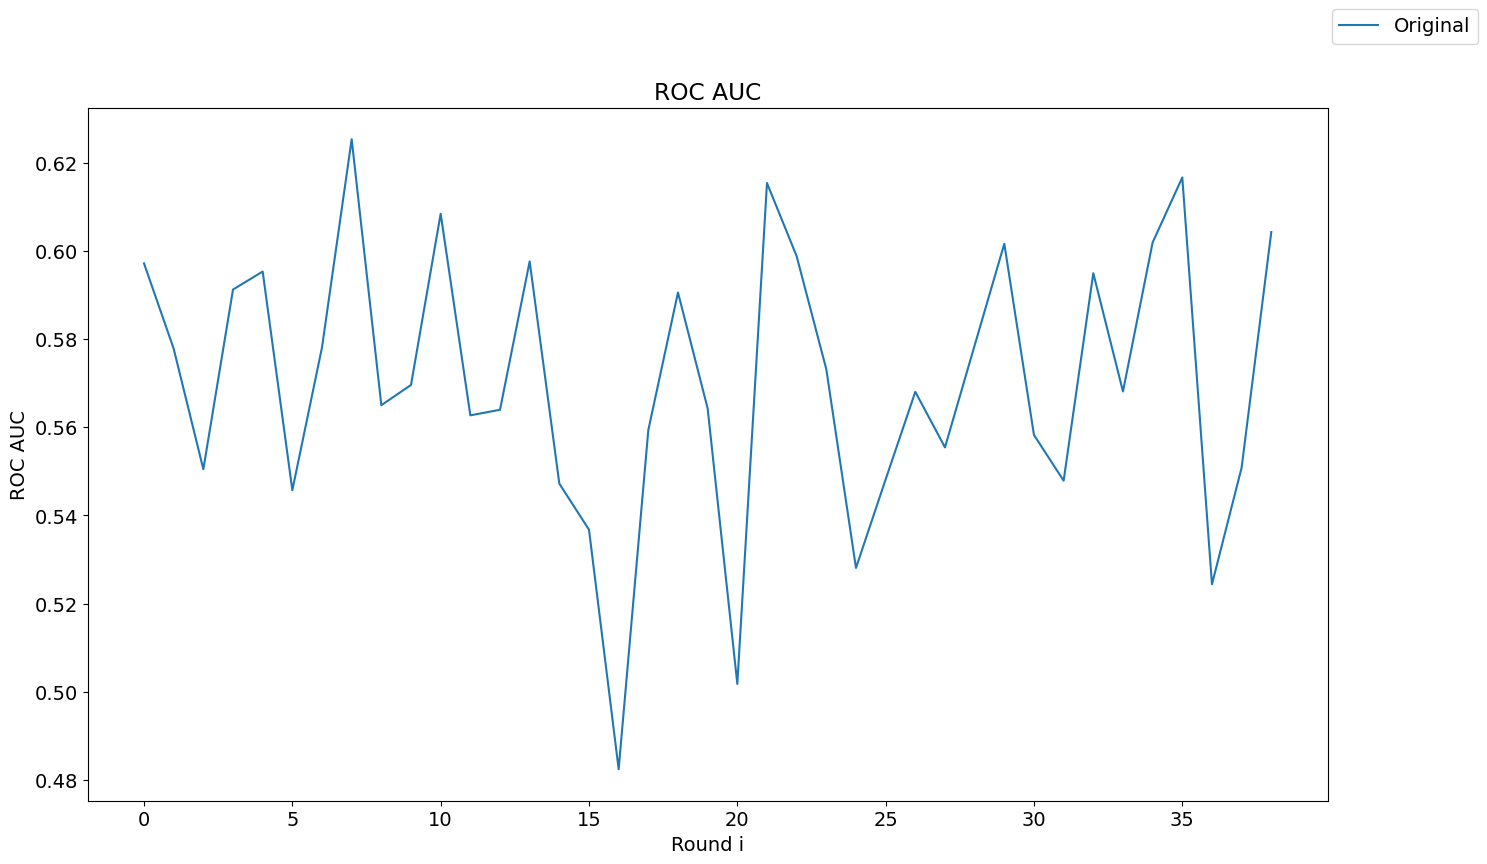

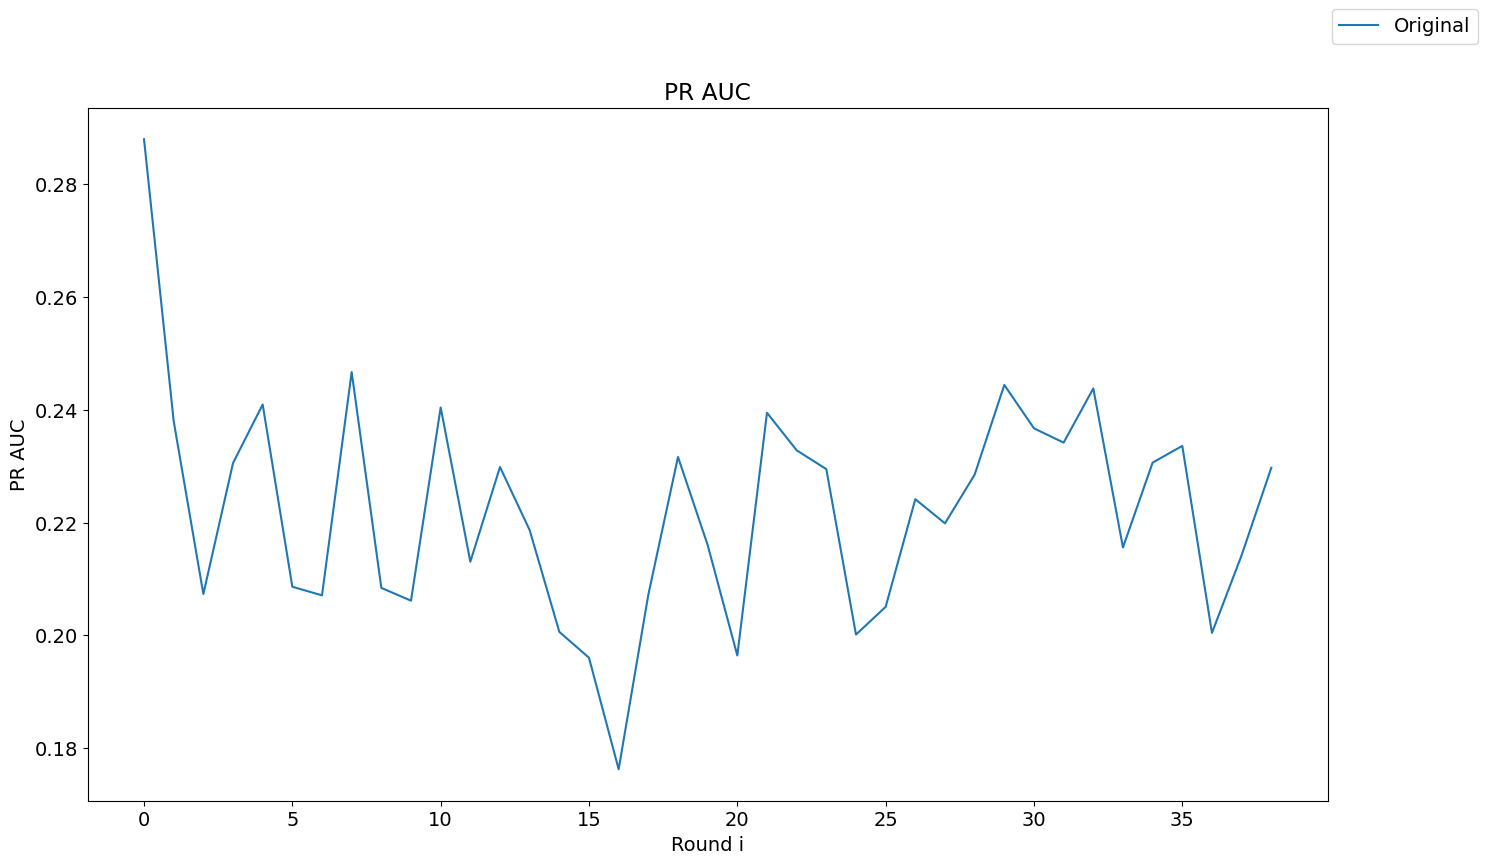

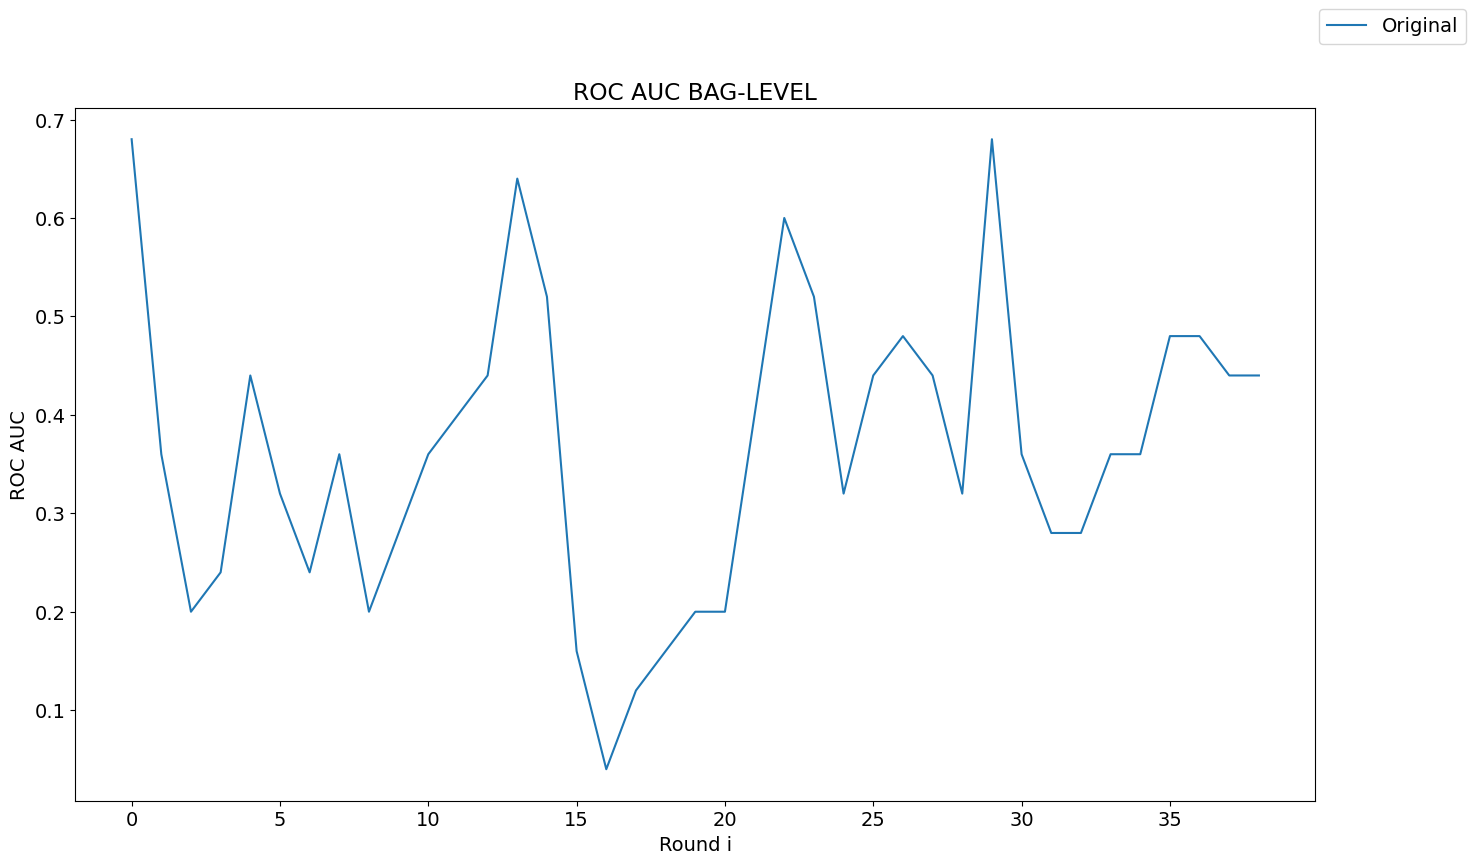

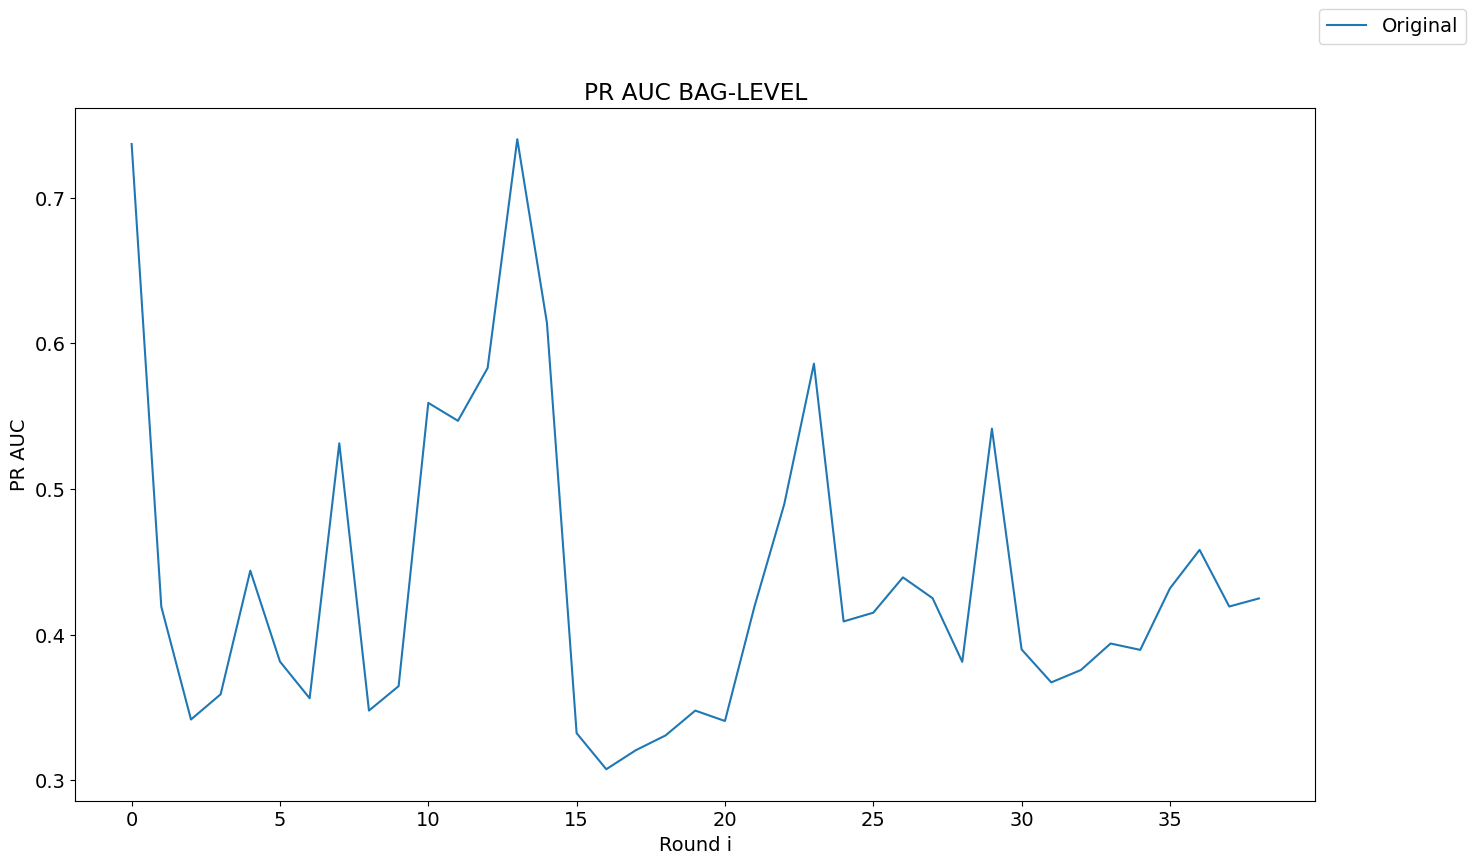

In [ ]:

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["roc"]
import csv
with open('auc_roc.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True or "X" in line[0]:
        if "aligned-random" == line[0]:
            line[0] = "aligned-random-continue"
        if "onepoch" in line[0]:
            x = line[0].split("onepoch")
            line[0] = "continue".join(x)
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.legend()
fig.savefig('img/ROC AUC.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["pr"]
import csv
with open('auc_pr.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.legend()
plt.show()
fig.savefig('img/PR AUC.png',bbox_inches='tight')
plt.close(fig)


## BAGLEVEL

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["rocbag"]
import csv
with open('auc_roc_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC BAG-LEVEL')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.savefig('img/ROC AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["prbag"]
import csv
with open('auc_pr_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC BAG-LEVEL')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.savefig('img/PR AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

In [ ]:
print(rewardInfo.getIterationEndRoundRobin())

30
